In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Library

In [1]:
import os
import warnings

import numpy as np # matrix
import pandas as pd # for csv file
import matplotlib.pyplot as plt
import seaborn as sns # for visualizing data
from pandas.api.types import CategoricalDtype
import tensorflow as tf
# lib for preb the data
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Mute warnings
warnings.filterwarnings('ignore')

model_scores = {}

# Data Preprocessing


In [4]:
def load_data():
    # read data
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train.csv")
    df.drop(["Id"], axis = 1, inplace =True)
    # Preprocessing
    df = clean(df) # Clean data to fix errors
    df = encode(df) # the statistical data type (numeric and categorical)
    df = impute(df) # missing value
    return df

In [5]:
# Some of the categorical features in this dataset have what are apparently typos in their categories:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train.csv", index_col = "Id")
df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [6]:
def clean(df):
    df.Exterior2nd = df.Exterior2nd.replace({"Brk Cmn" : "BrkComn"})
    # Names beginning with numbers are awkward to deal with
    df.rename(columns = { "1stFlrSF": "FirstFlrSF", "2ndFlrSF": "SecondFlrSF", "3SsnPorch": "Threeseasonporch"}, inplace = True)
    return df

In [7]:
# Encodeing each feature with its correcrt type help ensure each feature is treated appropriately by whatever funtions we use
# and make it easier for us to apply transformations consistently
# The numeric feature is already encoded correctly ("float" for continuos and "int" for concrete)
# Some feature is read as an "int" type, but it is actually a categorical 
# Two types of categorical features is nominative and ordinal

# Read the description we can see
# The nominative categorical features
nom_features = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig","Neighborhood", "Condition1",
                "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st","Exterior2nd", "MasVnrType",
                "Foundation", "Heating", "CentralAir", "GarageType","MiscFeature","SaleType", "SaleCondition"]

# The ordinal categorical features

# Pandas calls the categorical "Levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(1,11))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

ordered_levels = { key : ["None"] + value for key,value in ordered_levels.items()}

def encode(df):
    #Nominal
    for col in nom_features:
        df[col] = df[col].astype("category")
        # Add None for missing values
        if "None" not in df[col].cat.categories:
            df[col].cat.add_categories("None", inplace = True)
    # Ordinal
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered = True))
    # Numeric
    int_col = [col for col in df.columns if df[col].dtype == "int64"]
    for col in int_col:
        df[col] = df[col].astype("float64")
    return df

def impute(df):
    for col in df.select_dtypes("number"):
        df[col] = df[col].fillna(0)
    for col in df.select_dtypes("category"):
        df[col] = df[col].fillna("None")
    return df

In [8]:
df = load_data()
X = df.copy()
y = X.pop("SalePrice")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   float64 
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

# Mutual Information Scores

In [9]:
# Mutual Information (MI) is a function to compute the relationship between features and the target values
# MI works with both numeric features and categorical features
# If a feature has the MI score high, it means the feature helps "separte" the target value

# Function to compute MI scores
def make_mi_scores(X,y):
    X = X.copy()
    # Labe Encoder in pandas
    for col in X.select_dtypes("category"):
        X[col], _ = X[col].factorize()
    # All discrete features should now have interger dtypes (int)
    
    # A Column having "int" dtype will return True
    # Discrete_featrures is a series full of boolean values
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X,y, discrete_features = discrete_features, random_state = 0)
    mi_scores = pd.Series(mi_scores, name = "MI scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

mi_scores = make_mi_scores(X,y)
mi_scores = mi_scores.round(2)
mi_scores.head(10)

OverallQual     0.57
Neighborhood    0.53
GrLivArea       0.48
GarageCars      0.37
TotalBsmtSF     0.37
YearBuilt       0.36
GarageArea      0.36
KitchenQual     0.33
BsmtQual        0.33
ExterQual       0.33
Name: MI scores, dtype: float64

In [10]:
# Drop all features having MI scores 0
def drop_uninformative(X,scores):
    return X.loc[:, scores>0.3]
X = drop_uninformative(X,mi_scores)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Neighborhood  1460 non-null   category
 1   OverallQual   1460 non-null   category
 2   YearBuilt     1460 non-null   float64 
 3   ExterQual     1460 non-null   category
 4   BsmtQual      1460 non-null   category
 5   TotalBsmtSF   1460 non-null   float64 
 6   FirstFlrSF    1460 non-null   float64 
 7   GrLivArea     1460 non-null   float64 
 8   KitchenQual   1460 non-null   category
 9   GarageCars    1460 non-null   float64 
 10  GarageArea    1460 non-null   float64 
dtypes: category(5), float64(6)
memory usage: 78.2 KB


In [11]:
def dataset():
    # Load data
    df = load_data()
    X = df.copy()
    y = X.pop("SalePrice")
    
    # Compute MI
    mi_scores = make_mi_scores(X,y)
    mi_scores = mi_scores.round(2)
    X = drop_uninformative(X,mi_scores)
    
    # log y
    y = np.log(y)
    return X,y

In [12]:
X,y = dataset()

In [13]:
X.head()

,Neighborhood,OverallQual,YearBuilt,ExterQual,BsmtQual,TotalBsmtSF,FirstFlrSF,GrLivArea,KitchenQual,GarageCars,GarageArea
0,CollgCr,7,2003.0,Gd,Gd,856.0,856.0,1710.0,Gd,2.0,548.0
1,Veenker,6,1976.0,TA,Gd,1262.0,1262.0,1262.0,TA,2.0,460.0
2,CollgCr,7,2001.0,Gd,Gd,920.0,920.0,1786.0,Gd,2.0,608.0
3,Crawfor,7,1915.0,TA,TA,756.0,961.0,1717.0,Gd,3.0,642.0
4,NoRidge,8,2000.0,Gd,Gd,1145.0,1145.0,2198.0,Gd,3.0,836.0


In [14]:
# cat codes columns for One_Hot
one_hot_col = [col for col in X.select_dtypes(["category"]).columns if X[col].nunique() <= 10]
for col in one_hot_col:
  X[col] = X[col].cat.codes

# label for label
label_col = [col for col in X.select_dtypes(["category"]).columns if X[col].nunique() > 10]

# label
label = LabelEncoder()
for col in label_col:
  X[col] = label.fit_transform(X[col])

# Numeric columns for scaling (Scale is sensitive for Linear Regressor and Neural Network)
num_col = X.select_dtypes(["number"]).columns

# Random Forest Regressor

In [15]:
# Cross_val_score for RandomForestRegressor
def CVS_random_forest(X,y,n = 200):
    X = X.copy()
    y = y.copy()
    model = RandomForestRegressor(n_estimators = n, random_state = 0)
    
    y = np.array(y).reshape(-1,1)
    # Scale y
    scale = StandardScaler()
    y = scale.fit_transform(y)
    # Cross_val scores
    # Scikit-learn has a convention where all metrics are defined so a high number is better. 
    # Using negatives here allows them to be consistent with that convention, 
    # though negative MAE is almost unheard of elsewhere
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores

In [16]:
CVS_random_forest(X,y)

0.1559634436216718

Text(0, 0.5, 'Loss')

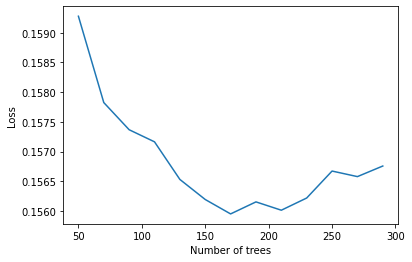

In [17]:
# Finding the value of n_estimators to help Random Forest models running with the best result
RFR_scores = pd.Series([])
for n in range(50,300,20):
    RFR_scores[n] = CVS_random_forest(X,y,n)
sns.lineplot(data = RFR_scores)
plt.xlabel("Number of trees")
plt.ylabel("Loss")

In [18]:
CVS_random_forest(X,y,170)

0.1559491930422375

In [19]:
def CVS_random_forest(X,y,n,max_features):
    X = X.copy()
    y = y.copy()
    model = RandomForestRegressor(n_estimators = n, max_features = max_features, random_state = 0)
    
    y = np.array(y).reshape(-1,1)
    # Scale y
    scale = StandardScaler()
    y = scale.fit_transform(y)
    # Cross_val scores
    # Scikit-learn has a convention where all metrics are defined so a high number is better. 
    # Using negatives here allows them to be consistent with that convention, 
    # though negative MAE is almost unheard of elsewhere
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores

Text(0, 0.5, 'Loss')

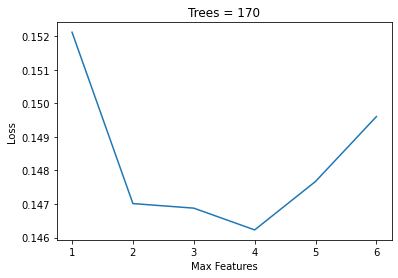

In [20]:
RFR_scores = pd.Series([])
for n in range(1,7,1):
    RFR_scores[n] = CVS_random_forest(X,y,170,n)
sns.lineplot(data = RFR_scores)
plt.title("Trees = 170")
plt.xlabel("Max Features")
plt.ylabel("Loss")

In [21]:
model_scores["Random Forest"] = RFR_scores[4]

In [22]:
def CVS_random_forest(X,y,min_samples_split):
    X = X.copy()
    y = y.copy()
    model = RandomForestRegressor(n_estimators = 170, max_features = 4,min_samples_split= min_samples_split, random_state = 0)
    
    y = np.array(y).reshape(-1,1)
    # Scale y
    scale = StandardScaler()
    y = scale.fit_transform(y)
    # Cross_val scores
    # Scikit-learn has a convention where all metrics are defined so a high number is better. 
    # Using negatives here allows them to be consistent with that convention, 
    # though negative MAE is almost unheard of elsewhere
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores

Text(0, 0.5, 'Loss')

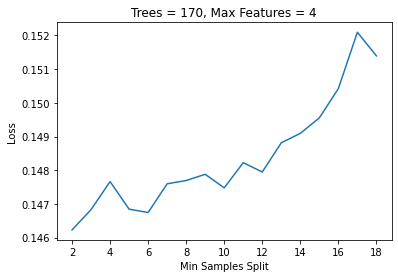

In [23]:
RFR_scores1 = pd.Series([])
for n in range(2,19,1):
    RFR_scores1[n] = CVS_random_forest(X,y,n)
sns.lineplot(data = RFR_scores1)
plt.title("Trees = 170, Max Features = 4")
plt.xlabel("Min Samples Split")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

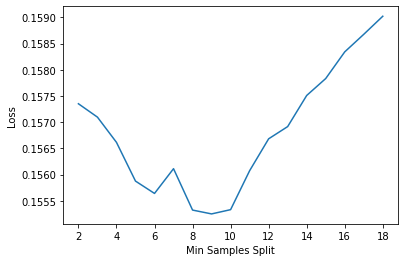

In [24]:
def CVS_random_forest(X,y,min_samples_split):
    X = X.copy()
    y = y.copy()
    model = RandomForestRegressor(min_samples_split= min_samples_split, random_state = 0)
    
    y = np.array(y).reshape(-1,1)
    # Scale y
    scale = StandardScaler()
    y = scale.fit_transform(y)
    # Cross_val scores
    # Scikit-learn has a convention where all metrics are defined so a high number is better. 
    # Using negatives here allows them to be consistent with that convention, 
    # though negative MAE is almost unheard of elsewhere
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores
RFR_scores2 = pd.Series([])
for n in range(2,19,1):
    RFR_scores2[n] = CVS_random_forest(X,y,n)
sns.lineplot(data = RFR_scores2)
plt.xlabel("Min Samples Split")
plt.ylabel("Loss")

In [25]:
# Cross_val_score for RandomForestRegressor
def CVS_random_forest(X,y,n):
    X = X.copy()
    y = y.copy()
    model = RandomForestRegressor(n_estimators = n,min_samples_split= 9, random_state = 0)
    
    y = np.array(y).reshape(-1,1)
    # Scale y
    scale = StandardScaler()
    y = scale.fit_transform(y)
    # Cross_val scores
    # Scikit-learn has a convention where all metrics are defined so a high number is better. 
    # Using negatives here allows them to be consistent with that convention, 
    # though negative MAE is almost unheard of elsewhere
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores

Text(0, 0.5, 'Loss')

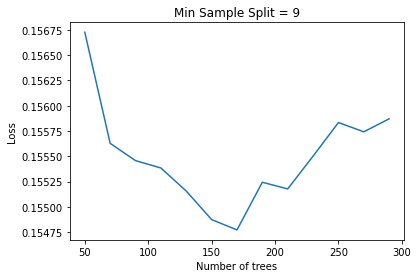

In [26]:
# Finding the value of n_estimators to help Random Forest models running with the best result
RFR_scores3 = pd.Series([])
for n in range(50,300,20):
    RFR_scores3[n] = CVS_random_forest(X,y,n)
sns.lineplot(data = RFR_scores3)
plt.title("Min Sample Split = 9")
plt.xlabel("Number of trees")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

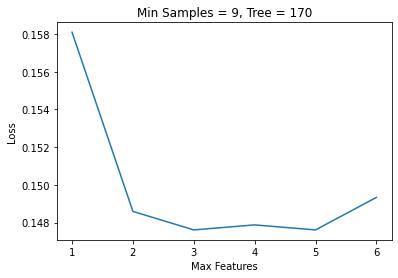

In [27]:
def CVS_random_forest(X,y,max_features):
    X = X.copy()
    y = y.copy()
    model = RandomForestRegressor(n_estimators = 170, min_samples_split= 9, max_features = max_features, random_state = 0)
    
    y = np.array(y).reshape(-1,1)
    # Scale y
    scale = StandardScaler()
    y = scale.fit_transform(y)
    # Cross_val scores
    # Scikit-learn has a convention where all metrics are defined so a high number is better. 
    # Using negatives here allows them to be consistent with that convention, 
    # though negative MAE is almost unheard of elsewhere
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores
RFR_scores4 = pd.Series([])
for n in range(1,7,1):
    RFR_scores4[n] = CVS_random_forest(X,y,n)
sns.lineplot(data = RFR_scores4)
plt.title("Min Samples = 9, Tree = 170")
plt.xlabel("Max Features")
plt.ylabel("Loss")

# Decision Tree

In [28]:
# Cross_val_score for Decision Tree
def CVS_decision_tree(X,y,min_samples_split):
    X = X.copy()
    y = y.copy()
    model = DecisionTreeRegressor( min_samples_split = min_samples_split)
    
    # Scale y
    y = np.array(y).reshape(-1,1)
    scale = StandardScaler()
    y = scale.fit_transform(y)
    
    # Cross_val scores
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores

In [29]:
CVS_decision_tree(X,y,20)

0.2380150946438345

Text(0, 0.5, 'Loss - MSE')

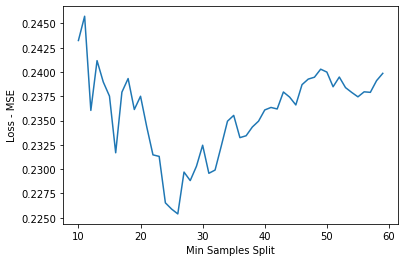

In [30]:
DT_scores1 = pd.Series([])
for n in range(10,60,1):
    DT_scores1[n] = CVS_decision_tree(X,y,n)
sns.lineplot(data = DT_scores1)
plt.xlabel("Min Samples Split")
plt.ylabel("Loss - MSE")

Text(0, 0.5, 'Loss - MSE')

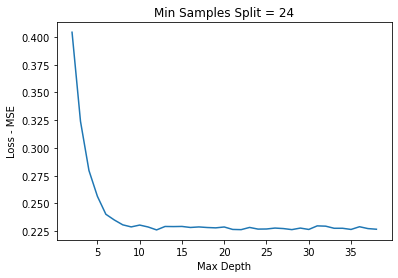

In [31]:
# Cross_val_score for Decision Tree
def CVS_decision_tree(X,y,n = 5):
    X = X.copy()
    y = y.copy()
    model = DecisionTreeRegressor( max_depth = n, min_samples_split = 24 )
    
    # Scale y
    y = np.array(y).reshape(-1,1)
    scale = StandardScaler()
    y = scale.fit_transform(y)
    
    # Cross_val scores
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores
DT_scores2 = pd.Series([])
for n in range(2,39,1):
    DT_scores2[n] = CVS_decision_tree(X,y,n)
sns.lineplot(data = DT_scores2)
plt.title("Min Samples Split = 24")
plt.xlabel("Max Depth")
plt.ylabel("Loss - MSE")

Text(0, 0.5, 'Loss - MSE')

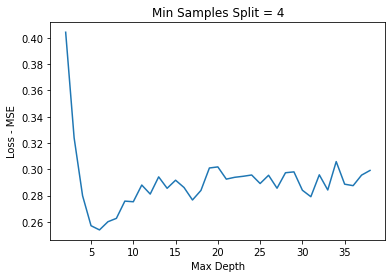

In [32]:
# Cross_val_score for Decision Tree
def CVS_decision_tree(X,y,n = 5):
    X = X.copy()
    y = y.copy()
    model = DecisionTreeRegressor( max_depth = n, min_samples_split = 4 )
    
    # Scale y
    y = np.array(y).reshape(-1,1)
    scale = StandardScaler()
    y = scale.fit_transform(y)
    
    # Cross_val scores
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores
DT_scores2 = pd.Series([])
for n in range(2,39,1):
    DT_scores2[n] = CVS_decision_tree(X,y,n)
sns.lineplot(data = DT_scores2)
plt.title("Min Samples Split = 4")
plt.xlabel("Max Depth")
plt.ylabel("Loss - MSE")

Text(0, 0.5, 'Loss - MSE')

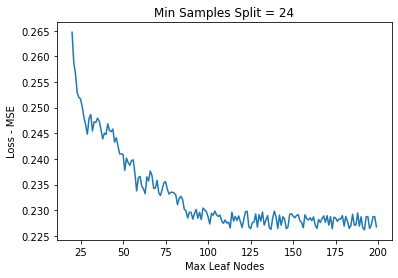

In [33]:
# Cross_val_score for Decision Tree
def CVS_decision_tree(X,y,n):
    X = X.copy()
    y = y.copy()
    model = DecisionTreeRegressor( max_leaf_nodes = n, min_samples_split = 24 )
    
    # Scale y
    y = np.array(y).reshape(-1,1)
    scale = StandardScaler()
    y = scale.fit_transform(y)
    
    # Cross_val scores
    scores = cross_val_score(model, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores
DT_scores3 = pd.Series([])
for n in range(20,200,1):
    DT_scores3[n] = CVS_decision_tree(X,y,n)
sns.lineplot(data = DT_scores3)
plt.title("Min Samples Split = 24")
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Loss - MSE")

In [34]:
model_scores["Decision Tree"]= DT_scores1[24]

# KNN

In [35]:
# Build a Pipeline for Cross Validation prevents data leaking
# Data Leakage happens when the training dataset and the validation dataset is not separate
# The validation data is used for evaluating the model
# The main idea for vaidation is the validation dataset must be not related to the training set, so the model does not know the
# existence of the validation set 
# Cross validation splits dataset to n folds, one fold for validation and the others is for training
# if the n folds have been applied some transform column techniques, two data sets are not separate
# KNN, linear Regressor and NN are better to perform with scaled data

# Cross_val_score for KNN
def CVS_knn(X,y,k = 5):
    X = X.copy()
    y = y.copy()
    model = KNeighborsRegressor(n_neighbors = k)
    
    # Pipeline
    
    # Scale
    numeric_transform = StandardScaler()
    
    # Column transform
    col_transform = ColumnTransformer(transformers = [
        ("num", numeric_transform, num_col)
    ])
    
    # Pipeline
    my_pipeline = Pipeline(steps = [
        ("col", col_transform),
        ("model", model)
    ])
    
    # Scale y
    y = np.array(y).reshape(-1,1)
    scale = StandardScaler()
    y = scale.fit_transform(y)
    
    # Cross_val scores
    scores = cross_val_score(my_pipeline, X, y, cv = 5 , scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return np.sqrt(scores)

In [36]:
CVS_knn(X,y)

0.4205504932179459

Text(0, 0.5, 'Loss - MSE')

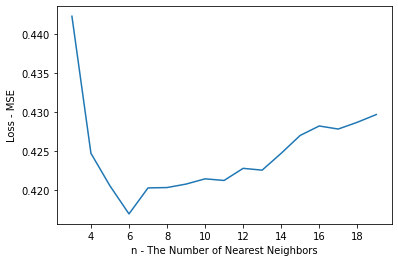

In [37]:
KNN_scores = pd.Series([])
for n in range(3,20,1):
    KNN_scores[n] = CVS_knn(X,y,n)
sns.lineplot(data = KNN_scores)
plt.xlabel("n - The Number of Nearest Neighbors")
plt.ylabel("Loss - MSE")

In [38]:
model_scores["KNN"]= KNN_scores[6]

# Linear Regressor

In [39]:
# Cross_val_score for LR
def CVS_LR(X,y):
    X = X.copy()
    y = y.copy()
    model = LinearRegression()
    
    # Pipeline
    
    # Scale
    numeric_transform = StandardScaler()
    
    # Column transform
    col_transform = ColumnTransformer(transformers = [
        ("num", numeric_transform, num_col)
    ])
    
    # Pipeline
    my_pipeline = Pipeline(steps = [
        ("col", col_transform),
        ("model", model)
    ])
    
    # Scale y
    y = np.array(y).reshape(-1,1)
    scale = StandardScaler()
    y = scale.fit_transform(y)
    
    # Cross_val scores
    scores = cross_val_score(my_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error")
    scores = -1 * scores.mean()
    return scores

In [40]:
CVS_LR(X,y)

0.18836536159970446

In [41]:
model_scores["Linear Regression"]= CVS_LR(X,y) 

# Neural Network

In [42]:
# Preb data
def preb_data(X,y):
    X = X.copy()
    y = y.copy()
    
    # Pipeline
    
    # Scale
    numeric_transform = StandardScaler()
    
    # Column transform
    col_transform = ColumnTransformer(transformers = [
        ("num", numeric_transform, num_col)
    ])
    X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size = 0.8, test_size = 0.2, random_state = 0)
    
    X_train = col_transform.fit_transform(X_train)
    X_valid = col_transform.transform(X_valid)
    y_train = np.array(y_train).reshape(-1,1)
    y_valid = np.array(y_valid).reshape(-1,1)
    # scale y
    scale = StandardScaler()
    y_train = scale.fit_transform(y_train)
    y_valid = scale.transform(y_valid)
    return X_train, X_valid, y_train, y_valid


X_train, X_valid, y_train, y_valid = preb_data(X,y)

In [43]:
# TPU
# detect the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # tìm thông tin TPU
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Initializing the TPU system: grpc://10.60.210.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.210.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [44]:
# model
with strategy.scope():
  # model
  inp = layers.Input((X_train.shape[1],))
  x = layers.Dense(512, activation ="relu")(inp)
  x = layers.Dense(256, activation ="relu")(x)
  x = layers.Dense(64, activation ="relu")(x)
  x = layers.Dense(1)(x)

  model = models.Model(inputs = inp, outputs = x)
  # compile
  model.compile(
      optimizer = "adam",
      loss = "mean_squared_error",
      metrics = ["MeanSquaredError"]
    )

In [45]:
# fitting
history = model.fit(
    X_train,y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 32,
    epochs = 150,
    verbose = 0
)
history_df = pd.DataFrame(history.history)

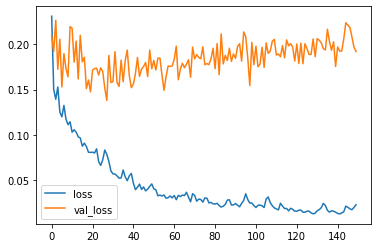

In [46]:
history_df.loc[:,["loss","val_loss"]].plot()

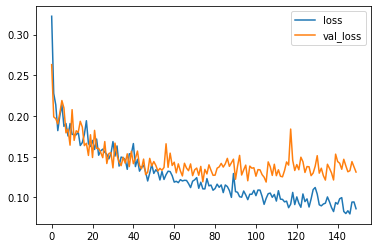

In [47]:
# Add Dropout and Early Stopping

# model
with strategy.scope():
  # model
  inp = layers.Input((X_train.shape[1],))
  x = layers.Dense(512, activation ="relu")(inp)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(256, activation ="relu")(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(64, activation ="relu")(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(1)(x)

  model = models.Model(inputs = inp, outputs = x)
  # compile
  model.compile(
      optimizer = "adam",
      loss = "mean_squared_error",
      metrics = ["MeanSquaredError"]
    )
# Early Stopping
early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 15,
    restore_best_weights = True
)
# fitting
history = model.fit(
    X_train,y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 32,
    epochs = 150,
    verbose = 0
)
history_df = pd.DataFrame(history.history)
history_df.loc[:,["loss","val_loss"]].plot()

In [48]:
y_preds = model.predict(X_valid)
model_scores["NN"] = mean_squared_error(y_valid, y_preds)

In [49]:
  # from tensorflow.keras.models import Model
  # seed = layers.Input((X_train.shape[1],))
  # x = layers.Dense(512, activation ="relu")(seed)
  # x = layers.Dropout(0.3)(x)
  # x = layers.Dense(256, activation ="relu")(x)
  # x = layers.Dropout(0.3)(x)
  # x = layers.Dense(64, activation ="relu")(x)
  # x = layers.Dropout(0.3)(x)
  # x = layers.Dense(1)(x)
  # model = Model(inputs = [seed], outputs = x)

In [50]:
# epochs = 50
# BATCH_SIZE = 32
# optimizer = tf.keras.optimizers.Adam()
# for i in range(epochs):
#   dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(BATCH_SIZE , drop_remainder= True)
#   for i, data in enumerate(dataset):
#     with tf.GradientTape() as tape:
#       y_preds = model(data[0], training = True)
#       loss = tf.reduce_mean(tf.keras.losses.MSE(data[1], y_preds))
#     gradient = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradient,model.trainable_variables))

In [51]:
# y_preds = model(X_valid, training = False)
# tf.reduce_mean(tf.keras.losses.MSE(y_valid, y_preds)).numpy()

# Compare 5 models

In [54]:
scores = pd.Series([])
# Compare 5 models
for keys, values in model_scores.items():
    scores[keys] = values
scores = scores.sort_values(ascending =  True)
scores

NN                   0.131231
Random Forest        0.146227
Linear Regression    0.188365
Decision Tree        0.226530
KNN                  0.416965
dtype: float64

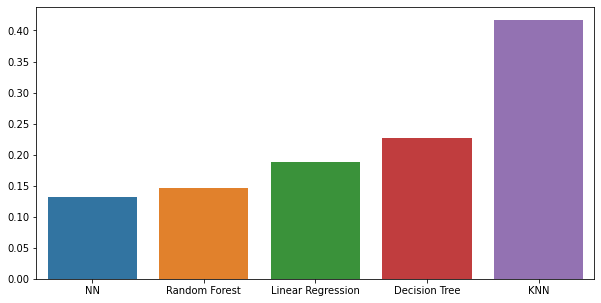

In [55]:
plt.figure(figsize=(10,5))
sns.barplot(x=scores.index, y=scores)